In [1]:
import sys, csv, time

import numpy as np
import pandas as pd

import geopandas as dpd

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, ElasticNet, OrthogonalMatchingPursuit
from sklearn.linear_model import Ridge, ARDRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from itertools import product

from utils import *

from group_lasso import GroupLasso
GroupLasso.LOG_LOSSES = True

import geopandas as gpd
from shapely.geometry import Point

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import rc
from matplotlib.lines import Line2D

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex = True)

# plt.rcParams['figure.facecolor'] = 'white'


plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
#mpl.rcParams['pdf.fonttype'] = 42

path_to_pds    = r"/Volumes/Extreme SSD/caiso_power/processed_data/"
path_to_aux    = r"/Volumes/Extreme SSD/caiso_power/output/auxiliary/"
path_to_maps    = r'/Users/Guille/Desktop/caiso_power/data/maps/'
path_to_data   = r"/Users/Guille/Desktop/caiso_power/data/"
path_to_images = r"/Users/Guille/Desktop/caiso_power/images/"


# Get Grid Dimensions
N = 104
M = 88

x_0 = -124.9965272954577
x_1 = -112.00305597999721
y_0 = 32.00083368070029
y_1 = 42.99708211754898

# Load the index of US land in the NOAA operational forecast
US_land_ = pd.read_pickle(path_to_aux + r"USland_0.125_(-125,-112)_(32,43).pkl")
# Load the index of Demand, Solar, and Wind land in the NOAA operational forecast
D_den_, S_den_, W_den_ = pd.read_pickle(path_to_aux + r"density_grid_0.125_(-125,-112)_(32,43).pkl")
print(US_land_.shape, D_den_.shape, S_den_.shape, W_den_.shape)

# Get California unlities and remove the ones that are not CAISO
_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_US    = gpd.read_file(path_to_maps + r"US/tl_2022_us_state.shp")
_CAISO = gpd.read_file(path_to_maps + r"CAISO/Balancing_Authority_Areas_in_CA.shp")
_CAISO_p = _CAISO.iloc[[1, 7]].to_crs("EPSG:4326")

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Extreme SSD/caiso_power/output/auxiliary/USland_0.125_(-125,-112)_(32,43).pkl'

In [ ]:
# Load Demand, Wind and Solar power plants in CAISO
S_ = pd.read_csv(path_to_aux + r'CAISO_solar.csv').to_numpy()
W_ = pd.read_csv(path_to_aux + r'CAISO_wind.csv').to_numpy()
P_ = pd.read_csv(path_to_aux + r'CAISO_population.csv').to_numpy()

# Loop over Grid coordinates
idx_ = []
for i in range(P_.shape[0]):
    if _CAISO_p.contains(Point([P_[:, 0][i], P_[:, 1][i]])).any():
        idx_.append(i)
        
_world['name']

In [ ]:
fig, ax = plt.subplots(1, figsize = (6., 6.))

plt.suptitle('Energy Demand and Generation', fontsize = 24)

_US.drop(13).to_crs("EPSG:4326").plot(ax        = ax, 
                                      linewidth = .75, 
                                      edgecolor = 'white', 
                                      facecolor = 'white',
                                      color     = '#B8B8B8', 
                                      zorder    = 2)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                linewidth = 1.5, 
                                edgecolor = 'white', 
                                facecolor = 'white', 
                                color     = '#B8B8B8', 
                                alpha     = 1., 
                                zorder    = 3)

_CAISO_p.to_crs("EPSG:4326").plot(ax        = ax, 
                                linewidth = 1.5, 
                                edgecolor = 'white', 
                                facecolor = 'white', 
                                color     = '#9F9F9F', 
                                alpha     = 1., 
                                zorder    = 3)

_world[_world['name'] == 'Mexico'].to_crs("EPSG:4326").plot(ax        = ax, 
                                                            linewidth = .5, 
                                                            edgecolor = 'white', 
                                                            facecolor = 'white',
                                                            color     = '#D3D3D3', 
                                                            alpha     = 1., 
                                                            zorder    = 1)
            
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.axis('off')

ax.scatter(S_[:, 0], S_[:, 1], c      = '#ffaf1d', 
                               s      = 5.*np.sqrt(S_[:, 2]), 
                               marker = 'o',
                               edgecolor = 'k', linewidth = .25,
                               alpha  = 0.5, 
                               zorder = 5, 
                               label  = 'Solar')

ax.scatter(W_[:, 0], W_[:, 1], c      = '#20b9f6', 
                               marker = 'o',
                               s      = 5.*np.sqrt(W_[:, 2]), 
                               alpha  = 0.5, edgecolor = 'k', linewidth = .25,
                               zorder = 6, 
                               label  = 'Wind')

ax.scatter(P_[idx_, 0], P_[idx_, 1], c      = 'teal', 
                                     marker = 'o',
                                     s      = np.sqrt(P_[idx_, 2])/2.,
                                     alpha  = .5, edgecolor = 'k', linewidth = .25,
                                     zorder = 4, 
                                     label  = 'Population')

ax.set_xlim(x_0, x_1)
ax.set_ylim(y_0, y_1)

legend_1_ = []

legend_1_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = '#ffaf1d', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                markersize      = 16, 
                                color           = "None"))

legend_1_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = '#ffaf1d', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                markersize      = 8, 
                                color           = "None"))

legend_1_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = '#ffaf1d', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                markersize      = 4, 
                                color           = "None"))

legend_1_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = '#20b9f6', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                markersize      = 16,
                                label           = '250 MW$^{ }$',
                                color           = "None"))

legend_1_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = '#20b9f6', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                label           = '100 MW$^{ }$',
                                markersize      = 8, 
                                color           = "None"))

legend_1_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = '#20b9f6', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                label           = '10 MW$^{ }$',
                                markersize      = 4, 
                                color           = "None"))
legend_2_ = []

legend_2_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = 'teal', 
                                markeredgecolor = 'k', 
                                markersize      = 16, markeredgewidth = .25,
                                label           = '4,000 per/km sq',
                                color           = "None"))

legend_2_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = 'teal', 
                                markeredgecolor = 'k',markeredgewidth = .25,
                                label           = '1,500 per/km sq',
                                markersize      = 8, 
                                color           = "None"))

legend_2_.append(Line2D([0], [0], marker          = '.', 
                                markerfacecolor = 'teal', 
                                markeredgecolor = 'k', markeredgewidth = .25,
                                label           = '100 per/km sq',
                                markersize      = 4, 
                                color           = "None"))

       
_leg_1 = ax.legend(handles        = legend_1_, 
                title          = r'Solar and Wind Assets', 
                loc            = 'upper right', 
                ncol           = 2, 
                columnspacing  = 0.25, 
                handletextpad  = 0.25,  
                bbox_to_anchor = [0.27, 0.225],
                frameon        = False)

ax.add_artist(_leg_1)

_leg_2 = ax.legend(handles        = legend_2_, 
                title          = r'Population Density', 
                loc            = 'upper right', 
                ncol           = 1, 
                columnspacing  = 0.25, 
                handletextpad  = 0.25,  
                bbox_to_anchor = [0.25, 0.45],
                frameon        = False)

ax.add_artist(_leg_2)


plt.savefig(path_to_images + "CAISO-map.pdf", bbox_inches = 'tight',
                                              dpi         = 250)

plt.show()

In [ ]:
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
rc('text', usetex = False)

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize']  = 18

def _make_plot(X_, label):
    
    ax.set_title(label, fontsize   = 20, 
                        fontweight = "bold")

    im = ax.imshow(X_, cmap   = 'turbo', 
                        origin = 'lower', 
                        zorder = 0, 
                        extent = [-124.9965272954577, -112.00305597999721, 32.00083368070029, 42.99708211754898])

    _US.to_crs("EPSG:4326").plot(ax        = ax, 
                                 linewidth = 1.5, 
                                 edgecolor = 'w', 
                                 facecolor = 'w',
                                 color     = 'None', zorder = 2)

    _CAISO.to_crs("EPSG:4326").plot(ax        = ax, 
                                    linewidth = 0.75, 
                                    edgecolor = 'w', 
                                    facecolor = 'w', 
                                    color     = 'None', 
                                    alpha     = 0.5, 
                                    zorder    = 3)


    ax.set_xlabel('Lon.', fontsize = 14)
    ax.set_ylabel('Lat.', fontsize = 14)

    ax.set_xlim(-124.9965272954577, -112.00305597999721)
    ax.set_ylim(32.00083368070029, 42.99708211754898)

M1_ = D_den_.reshape(M, N)
M2_ = S_den_.reshape(M, N)
M3_ = W_den_.reshape(M, N)

masks_ = [M1_, M2_, M3_]
labels_ = [r'Potulation Density Mask ($\mathbf{M}^{\mathcal{L}}$)', 
           r'Solar Assets Mask ($\mathbf{M}^{\mathcal{S}}$)', 
           r'Wind Assets Mask ($\mathbf{M}^{\mathcal{W}}$)']

fig, ax = plt.subplots(1, 3, figsize = (17.5, 5), 
                             squeeze = True)

for i in range(3):
    
    ax = plt.subplot(1, 3, i + 1) 
    _make_plot(np.nan_to_num(masks_[i]), labels_[i])
    
plt.savefig(path_to_images + "spatial_masks.pdf", bbox_inches = 'tight',
                                                  dpi         = 350)

plt.show()

In [ ]:

fig, ax_ = plt.subplots(nrows   = 1, 
                        ncols   = 3, 
                        figsize = (15, 4.25))

fig.set_facecolor('white')

#plt.suptitle('NOAA HRRR (ac)', fontsize = 20)

ax_[0].title.set_text('Demand Mask')

# divider = make_axes_locatable(ax_[0])
# ax_cb = divider.append_axes("right", size = "5%", pad = 0.05)

_US.to_crs("EPSG:4326").plot(ax        = ax_[0], 
                                linewidth = 1.25, 
                                edgecolor = 'k', 
                                facecolor = 'k',
                                color     = 'None', zorder = 1)

im = ax_[0].imshow(M1_ > 0., cmap   = 'BuGn', 
                             origin = 'lower', 
                             zorder = 0, 
                             extent = [-125, -112, 32, 43])

# cbar = plt.colorbar(im, cax = ax_cb)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_[0], 
                                linewidth = .5, 
                                edgecolor = 'k', 
                                facecolor = 'k', 
                                color     = 'None', 
                                alpha = 0.5, 
                                zorder = 2)

ax_[0].set_xticks([], [])
ax_[0].set_yticks([], [])
ax_[0].set_ylim(32, 43)
ax_[0].set_xlim(-125, -112.5)
ax_[0].text(-0.1, 1.1, 'A', transform = ax_[0].transAxes, size = 20, weight = 'bold')

ax_[1].title.set_text('Solar Mask')

# divider = make_axes_locatable(ax_[1])
# ax_cb = divider.append_axes("right", size = "5%", pad = 0.05)

_US.to_crs("EPSG:4326").plot(ax        = ax_[1], 
                             linewidth = 1.25, 
                             edgecolor = 'k', 
                             facecolor = 'k',
                             color     = 'None', 
                             zorder    = 1)

im = ax_[1].imshow(M2_ > 0., cmap   = 'Oranges', 
                             origin = 'lower', 
                             zorder = 0, 
                             extent = [-125, -112, 32, 43])

#cbar = plt.colorbar(im, cax = ax_cb)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_[1], 
                                linewidth = .5, 
                                edgecolor = 'k', 
                                facecolor = 'k', 
                                color     = 'None', 
                                alpha     = 0.5, 
                                zorder    = 2)

ax_[1].set_xticks([], [])
ax_[1].set_yticks([], [])
ax_[1].set_ylim(32, 43)
ax_[1].set_xlim(-125, -112.5)
ax_[1].text(-0.1, 1.1, 'B', transform = ax_[1].transAxes, size = 20, weight = 'bold')

ax_[2].title.set_text('Wind Mask')

# divider = make_axes_locatable(ax_[2])
# ax_cb = divider.append_axes("right", size = "5%", pad = 0.05)

_US.to_crs("EPSG:4326").plot(ax        = ax_[2], 
                             linewidth = 2., 
                             edgecolor = 'k', 
                             facecolor = 'k',
                             color     = 'None', 
                             zorder    = 1)

im = ax_[2].imshow(M3_ > 0., cmap   = 'Blues', 
                             origin = 'lower', 
                             zorder = 0, 
                             extent = [-125, -112, 32, 43])


# cbar = plt.colorbar(im, cax = ax_cb)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_[2], 
                                linewidth = 1., 
                                edgecolor = 'k', 
                                facecolor = 'k', 
                                color     = 'None', 
                                alpha     = 0.5, 
                                zorder    = 2)

ax_[2].set_xticks([], [])
ax_[2].set_yticks([], [])
ax_[2].set_ylim(32, 43)
ax_[2].set_xlim(-125, -112.5)
ax_[2].text(-0.1, 1.1, 'C', transform = ax_[2].transAxes, size=20, weight='bold')
    
#plt.savefig(path_to_images + "NOAA_{}-{}.pdf".format(i_day, i_hour), dpi = 100)
plt.show()

In [ ]:
# # Load data in a compressed file
# def _load_data_in_chunks(years_, path):
#     # Open a BLOSC compressed file
#     def __load_data_in_compressed_file(file):
#         with open(file, "rb") as f:
#             data_ = f.read()
#         return pickle.loads(blosc.decompress(data_))
#     # Loop over processed years
#     data_ = []
#     for year in years_:
#         # Find processed data from that year
#         files_ = glob.glob(path + "{}_*".format(year))
#         # Define the maximum feasible number of chunks
#         N_min_chunks = len(files_)
#         # Loop over all possible chunks
#         for i in range(N_min_chunks):
#             V_, W_, X_, Y_, Z_ = [], [], [], [], []
#             for j in range(N_min_chunks):
#                 # Load data if extis
#                 try:
#                     file_name = path + "{}_{}-{}.dat".format(year, i, j)
#                     data_p_   = __load_data_in_compressed_file(file_name)
#                     # Append together all chucks
#                     V_.append(data_p_[0])
#                     W_.append(data_p_[1])
#                     X_.append(data_p_[2])
#                     Y_.append(data_p_[3])
#                     Z_.append(data_p_[4])
#                     print(file_name)
#                 except:
#                     continue
#             # Concatenate data if files existed
#             if len(X_) > 0:
#                 V_ = np.concatenate(V_, axis = 0)
#                 W_ = np.concatenate(W_, axis = 0)
#                 X_ = np.concatenate(X_, axis = 0)
#                 Y_ = np.concatenate(Y_, axis = 0)
#                 Z_ = np.concatenate(Z_, axis = 0)
#                 data_.append([V_, W_, X_, Y_, Z_])
#     return data_

# # Load propossed data
# data_ = _load_data_in_chunks([2023], path_to_pds)
# print(len(data_))

In [ ]:
# # v = {MWD (ac), PGE (ac), SCE (ac), SDGE (ac), VEA (ac), NP15 solar (ac), SP15 solar (ac), ZP26 solar (ac), NP15 wind (ac), SP15 wind (ac)}
# # w = {MWD (fc), PGE (fc), SCE (fc), SDGE (fc), VEA (fc), NP15 solar (fc), SP15 solar (fc), ZP26 solar (fc), NP15 wind (fc), SP15 wind (fc)}
# # X = {PRES (ac), DSWRF (ac), DLWRF (ac), DPT (ac), RH (ac), TMP (ac), W_10 (ac), W_60 (ac), W_80 (ac), W_100 (ac), W_120 (ac), 
# #      DI (ac), WC (ac), HCDH (ac), GSI (ac)}
# # Y = {PRES (fc), PRATE (fc), DSWRF (fc), DLWRF (fc), DPT (fc), RH (fc), TMP (fc), W_10 (fc), W_60 (fc), W_80 (fc), W_100 (fc), W_120 (fc),
# #      DI (fc), WC (fc), HCDH (fc), GSI (fc)}
# # z = {year, month, day, yday, hour, weekday, weekend, isdst, holiday}
# # DSWRF = Diffuse Radiation
# # Is only water pumping... (?)
# def _structure_dataset(data_, i_resource, v_idx_ = [[0, 1, 2, 3, 4], [5, 6, 7], [8, 9]],
#                                           w_idx_ = [[0, 1, 2, 3, 4], [5, 6, 7], [8, 9]],
#                                           x_idx_ = [[0, 2, 3, 4, 5, 11, 12, 13], [1, 2, 14], [6, 7, 8, 9, 10]],
#                                           y_idx_ = [[0, 1, 3, 4, 5, 6, 12, 13, 14], [2, 3, 15], [7, 8, 9, 10, 11]],
#                                           z_idx_ = [[0], [0, 1, 2, 3, 4, 5, 6, 7, 8], [2, 3, 6, 7]],
#                                           F_idx_ = None):
#     v_idx_ = v_idx_[i_resource]
#     w_idx_ = w_idx_[i_resource]
#     x_idx_ = x_idx_[i_resource]
#     y_idx_ = y_idx_[i_resource]
#     z_idx_ = z_idx_[i_resource]
#     #F_idx_ = F_idx_[i_resource]
#     # Concatenate all chucks of data in matrix form
#     V_, W_, X_, Y_, Z_ = [], [], [], [], []
#     for i in range(len(data_)):
#         V_.append(data_[i][0][:, v_idx_])
#         W_.append(data_[i][1][:, w_idx_])
#         X_.append(data_[i][2][:, x_idx_, :])
#         Y_.append(data_[i][3][:, y_idx_, :])
#         Z_.append(data_[i][4][:, z_idx_])
#     V_ = np.concatenate(V_, axis = 0)
#     W_ = np.concatenate(W_, axis = 0)
#     X_ = np.concatenate(X_, axis = 0)
#     Y_ = np.concatenate(Y_, axis = 0)
#     Z_ = np.concatenate(Z_, axis = 0)
#     print(V_.shape, W_.shape, X_.shape, Y_.shape, Z_.shape)
#     # Apply features selection heuristic
#     V_p_ = V_[:, :]
#     W_p_ = W_[:, :]
#     X_p_ = X_[..., F_idx_ > 0.]
#     Y_p_ = Y_[..., F_idx_ > 0.]
#     print(1, X_p_.shape)
#     G_p_ = np.concatenate([i*np.ones((1, X_p_.shape[-1])) for i in range(X_p_.shape[-2])], axis = 0)
#     #G_p_ = np.concatenate([i*np.ones((X_p_.shape[-2],1)) for i in range(X_p_.shape[-1])], axis = 1)
#     print(V_p_.shape, W_p_.shape, X_p_.shape, Y_p_.shape, G_p_.shape)
#     del V_, W_, X_, Y_
#     # Concatenate all the dimensions
#     X_pp_, Y_pp_, G_pp_ = [], [], []
#     for d in range(X_p_.shape[1]):
#         X_pp_.append(X_p_[:, d, :])
#         Y_pp_.append(Y_p_[:, d, :])
#         G_pp_.append(G_p_[d, :])
#     X_pp_ = np.concatenate(X_pp_, axis = -1)
#     Y_pp_ = np.concatenate(Y_pp_, axis = -1)
#     G_pp_ = np.concatenate(G_pp_, axis = -1)
#     print(X_pp_.shape, Y_pp_.shape, G_pp_.shape)
#     del X_p_, Y_p_, G_p_
#     # Concatenate by hours
#     V_pp_, W_pp_, X_ppp_, Y_ppp_, Z_p_ = [], [], [], [], []
#     for n in range(int(V_p_.shape[0]/24)):
#         k = n*24
#         l = (n + 1)*24
#         V_pp_.append(V_p_[k:l, ...][:,np.newaxis])
#         W_pp_.append(W_p_[k:l, ...][:, np.newaxis])
#         X_ppp_.append(X_pp_[k:l, ...][:, np.newaxis, :])
#         Y_ppp_.append(Y_pp_[k:l, ...][:, np.newaxis, :])
#         Z_p_.append(Z_[k:l, ...][:, np.newaxis, :])
#     V_pp_  = np.concatenate(V_pp_, axis = 1)
#     W_pp_  = np.concatenate(W_pp_, axis = 1)
#     X_ppp_ = np.concatenate(X_ppp_, axis = 1)
#     Y_ppp_ = np.concatenate(Y_ppp_, axis = 1)
#     Z_p_   = np.concatenate(Z_p_, axis = 1)
#     return V_pp_, W_pp_, X_ppp_, Y_ppp_, Z_p_, G_pp_
#     #return V_pp_, V_p_, X_pp_, Y_ppp_, Z_p_

    
# i_resource = 2
# i_asset    = 0
# i_filter   = 2

# print(data_[0][0].shape, data_[0][1].shape, data_[0][2].shape, data_[0][3].shape, data_[0][4].shape)

# print(data_[0][4][0, :])
# print(data_[0][4][0, :], data_[0][0][: ,:5].shape)

# # Define data structure for a given experiment
# Y_ac_, Y_fc_, X_ac_, X_fc_, Z_, G_ = _structure_dataset(data_, i_resource, F_idx_ = [np.ones(US_land_.shape), 
#                                                                                      US_land_,
#                                                                                      [D_den_, S_den_, W_den_][i_resource]][i_filter])
# print(Y_ac_.shape, Y_fc_.shape, X_ac_.shape, X_fc_.shape, Z_.shape, G_.shape)
# #Y_ac_ = Y_ac_[..., i_asset][..., np.newaxis]
# #Y_fc_ = Y_fc_[..., i_asset][..., np.newaxis]
# #print(Y_ac_.shape, Y_fc_.shape)

In [ ]:
# Assets in resources: {load:5, solar:3, wind:2}
i_resource = 1
# Resources: [{MWD, PGE, SCE, SDGE, VEA}, {NP, SP, ZP}, {NP, SP}]
i_asset = 1
# Parameters combination to run in the experiments:
# Spatial masks {All, US Land, All CAISO Resources density, Resource density}
i_mask = 0
tau    = 0.

# Define spatial feature masks
M_ = [np.ones(US_land_.shape), US_land_, D_den_ + S_den_ + W_den_, [D_den_, S_den_, W_den_][i_resource]]

# Load proposed data
data_ = _load_data_in_chunks([2023], path_to_pds)

# Define data structure for a given experiment
Y_ac_, Y_fc_, X_ac_, X_fc_, Z_, g_sl_, g_dl_ = _structure_dataset(data_, i_resource, M_[i_mask], tau)
print(Y_ac_.shape, Y_fc_.shape, X_ac_.shape, X_fc_.shape, Z_.shape, g_sl_.shape, g_dl_.shape)
#Y_ac_ = Y_ac_[..., i_asset][..., np.newaxis]
#Y_fc_ = Y_fc_[..., i_asset][..., np.newaxis]
print(Y_ac_.shape, Y_fc_.shape)

In [ ]:
i_hour = 13
i_day  = 20

x_ac_ = X_ac_[i_hour, i_day, :].reshape(3, M, N)
x_fc_ = X_fc_[i_hour, i_day, :].reshape(3, M, N)

print(x_ac_.shape, x_fc_.shape)

fig, ax_ = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4.25))

fig.set_facecolor('white')

#plt.suptitle('NOAA HRRR (ac)', fontsize = 20)

ax_[0].title.set_text('Direct Solar Radiation')

divider = make_axes_locatable(ax_[0])
ax_cb = divider.append_axes("right", size = "5%", pad = 0.05)


im = ax_[0].imshow(x_ac_[0, ...], cmap   = 'magma', 
                                  origin = 'lower', 
                                  zorder = 0, 
                                  extent = [-125, -112, 32, 43], 
                                  vmin   = 0, 
                                  vmax   = 1000)


_US.to_crs("EPSG:4326").plot(ax        = ax_[0], 
                             linewidth = 1.5, 
                             edgecolor = 'k', 
                             facecolor = 'k',
                             color     = 'None', zorder = 1)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_[0], 
                                linewidth = .75, 
                                edgecolor = 'k', 
                                facecolor = 'k', 
                                color     = 'None', 
                                alpha = 0.5, zorder = 2)

cbar = plt.colorbar(im, cax = ax_cb)

ax_[0].set_xticks([], [])
ax_[0].set_yticks([], [])
ax_[0].set_xlim(-125, -112)
ax_[0].set_ylim(32, 43)
ax_[0].text(-0.1, 1.1, 'A', transform = ax_[0].transAxes, size = 20, weight = 'bold')

ax_[1].title.set_text('Diffuse Solar Radiation')

divider = make_axes_locatable(ax_[1])
ax_cb = divider.append_axes("right", size = "5%", pad = 0.05)

im = ax_[1].imshow(x_ac_[1, ...], cmap   = 'magma', 
                                    origin = 'lower', 
                                    zorder = 0, 
                                    extent = [-125, -112, 32, 43], 
                                    vmin   = 0, 
                                    vmax   = 500)

cbar = plt.colorbar(im, cax = ax_cb)

_US.to_crs("EPSG:4326").plot(ax        = ax_[1], 
                             linewidth = 1.5, 
                             edgecolor = 'k', 
                             facecolor = 'k',
                             color     = 'None', 
                             zorder    = 1)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_[1], 
                                linewidth = .75, 
                                edgecolor = 'k', 
                                facecolor = 'k', 
                                color     = 'None', 
                                alpha     = 0.5, 
                                zorder    = 2)

ax_[1].set_xticks([], [])
ax_[1].set_yticks([], [])
ax_[1].set_xlim(-125, -112)
ax_[1].set_ylim(32, 43)
ax_[1].text(-0.1, 1.1, 'B', transform = ax_[1].transAxes, size = 20, weight = 'bold')

ax_[2].title.set_text('Clear-Sky Solar Radiation')

divider = make_axes_locatable(ax_[2])
ax_cb = divider.append_axes("right", size = "5%", pad = 0.05)

im = ax_[2].imshow(x_ac_[2, ...], cmap   = 'magma', 
                                  origin = 'lower', 
                                  zorder = 0, 
                                  extent = [-125, -112, 32, 43], 
                                  vmin   = 0,
                                  vmax   = 1000)

_US.to_crs("EPSG:4326").plot(ax        = ax_[2], 
                             linewidth = 1.5, 
                             edgecolor = 'k', 
                             facecolor = 'k',
                             color     = 'None', zorder = 1)

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_[2], 
                                linewidth = .75, 
                                edgecolor = 'k', 
                                facecolor = 'k', 
                                color     = 'None', 
                                alpha     = 0.5, 
                                zorder    = 2)

cbar = plt.colorbar(im, cax = ax_cb)



ax_[2].set_xticks([], [])
ax_[2].set_yticks([], [])
ax_[2].set_xlim(-125, -112)
ax_[2].set_ylim(32, 43)
ax_[2].text(-0.1, 1.1, 'C', transform = ax_[2].transAxes, size = 20, weight ='bold')
    
#plt.savefig(path_to_images + "NOAA_{}-{}.pdf".format(i_day, i_hour), dpi = 100)
plt.show()

In [ ]:
# Cross-validation configuration
N_lags = 6
N_hyps = 7
tau    = 0.
# Assets in resources: {load:5, solar:3, wind:2}
i_resource = 1
# Resources: [{MWD, PGE, SCE, SDGE, VEA}, {NP, SP, ZP}, {NP, SP}]
i_asset = 1
# Parameters combination to run in the experiments:
# Spatial masks {All, US Land, All CAISO Resources density, Resource density}
i_mask = 3
# Autoregressive series from today:
AR = 1
# Cyclo-stationary from lagged series
CS = 1
# Time dammy variables
TM = 1
# Include predictions recursively in features
RC = 1
# features standardization
x_sl_stnd = 0
x_dl_stnd = 0
# Signals standardization
y_sl_stnd = 1
y_dl_stnd = 1
# Sparse learning model index
SL = 0
# Dense learning model index
DL = 0

key = '{}{}_{}{}{}{}_{}{}_{}{}_{}{}'.format(N_lags, i_mask, AR, CS, TM, RC, x_sl_stnd, y_sl_stnd, x_dl_stnd, y_dl_stnd, SL, DL)
print(key)

# Define spatial feature masks
M_ = [np.ones(US_land_.shape), US_land_, D_den_ + S_den_ + W_den_, [D_den_, S_den_, W_den_][i_resource]]

# Load proposed data
data_ = _load_data_in_chunks([2023], path_to_pds)

i_theta_ = [5, 5, 5]

# Define data structure for a given experiment
Y_ac_, Y_fc_, X_ac_, X_fc_, Z_, g_sl_, g_dl_ = _structure_dataset(data_, i_resource, M_[i_mask], tau)
print(Y_ac_.shape, Y_fc_.shape, X_ac_.shape, X_fc_.shape, Z_.shape, g_sl_.shape, g_dl_.shape)
#Y_ac_ = Y_ac_[..., i_asset][..., np.newaxis]
#Y_fc_ = Y_fc_[..., i_asset][..., np.newaxis]
print(Y_ac_.shape, Y_fc_.shape)

In [ ]:
# Generate spare learning dataset
X_sl_, Y_sl_, g_sl_ = _dense_learning_dataset(X_ac_, Y_ac_, Z_, g_sl_, N_lags, AR = 0, CS = 0, TM = 1)
print(X_sl_.shape, Y_sl_.shape, g_sl_.shape)

# Split data in training and testing
X_sl_tr_, X_sl_ts_ = _training_and_testing_dataset(X_sl_)
Y_sl_tr_, Y_sl_ts_ = _training_and_testing_dataset(Y_sl_)
#print(X_sl_tr_.shape, Y_sl_tr_.shape, X_sl_ts_.shape, Y_sl_ts_.shape)
del X_ac_, X_sl_, Y_sl_

# Generate dense learning dataset
X_dl_, Y_dl_, g_dl_ = _dense_learning_dataset(X_fc_, Y_ac_, Z_, g_dl_, N_lags, AR, CS, TM)
#print(X_dl_.shape, Y_dl_.shape, g_dl_.shape)

# Split data in training and testing
X_dl_tr_, X_dl_ts_ = _training_and_testing_dataset(X_dl_)
Y_dl_tr_, Y_dl_ts_ = _training_and_testing_dataset(Y_dl_)
#print(X_dl_tr_.shape, Y_dl_tr_.shape, X_dl_ts_.shape, Y_dl_ts_.shape)
del X_fc_, X_dl_, Y_dl_, Z_

# Naive and CAISO forecasts as baselines
Y_per_fc_, Y_ca_fc_, Y_clm_fc_ = _naive_forecasts(Y_ac_, Y_fc_, N_lags)
#print(Y_per_fc_.shape, Y_ca_fc_.shape, Y_clm_fc_.shape)
del Y_ac_, Y_fc_

# Generate spase learning training and testing dataset in the correct format
X_sl_tr_test_, Y_sl_tr_test_ = _sparse_learning_dataset(X_sl_tr_, Y_sl_tr_)
X_sl_ts_test_, Y_sl_ts_test_ = _sparse_learning_dataset(X_sl_ts_, Y_sl_ts_)
print(X_sl_tr_test_.shape, Y_sl_tr_test_.shape, X_sl_ts_test_.shape, Y_sl_ts_test_.shape)

# Standardize sparse learning dataset
X_sl_tr_stnd_, Y_sl_tr_stnd_, X_sl_ts_stnd_, sl_scaler_ = _spare_learning_stand(X_sl_tr_test_, Y_sl_tr_test_, X_sl_ts_test_, x_sl_stnd, y_sl_stnd)
#print(X_sl_tr_stnd_.shape, Y_sl_tr_stnd_.shape, X_sl_ts_stnd_.shape)

# Sparse and dense learning hyper-parameters
if x_sl_stnd == 0: alphas_ = np.logspace(-4, 2, N_hyps)
else:              alphas_ = np.logspace(-4, 2, N_hyps)/500.
betas_   = np.linspace(10, X_sl_tr_.shape[1]/2., N_hyps, dtype = int)
omegas_  = np.logspace(-2, 0, N_hyps - 3)[:-1]
gammas_  = np.logspace(0, 3, N_hyps - 3)[:-1]
etas_    = np.logspace(-4, 2, N_hyps)
lambdas_ = np.logspace(-1, 5, N_hyps)
xis_     = np.linspace(0, N_hyps - 1, N_hyps, dtype = int)
# Get combination of possible parameters
thetas_, N_thetas = _get_cv_param(alphas_, betas_, omegas_, gammas_, etas_, lambdas_, xis_, SL, DL)

# Initialization prediction mean and weights
Y_sl_ts_hat_test_ = np.zeros(Y_sl_ts_test_.shape)
W_hat_            = np.zeros((X_sl_ts_stnd_.shape[1], Y_sl_ts_test_.shape[1]))
#print(Y_sl_ts_hat_test_.shape, W_hat_.shape)
# Train independent multi-task models for each hour
for tsk in range(Y_sl_ts_test_.shape[1]):
    print(SL, tsk, X_sl_tr_stnd_.shape, Y_sl_tr_stnd_.shape, Y_sl_ts_hat_test_.shape)
    # Lasso (linear regression with l_1 norm applied to the coefficients.)
    if SL == 0: _SL = Lasso(alpha = thetas_[i_theta_[tsk]][0], max_iter = 2000, tol = 0.001).fit(X_sl_tr_stnd_, Y_sl_tr_stnd_[:, tsk])
    # Orthogonal Matching Persuit (linear regression with l_0 norm applied to the coefficients.)
    if SL == 1: _SL = OrthogonalMatchingPursuit(n_nonzero_coefs = thetas_[i_theta_[tsk]][0], normalize = False).fit(X_sl_tr_stnd_, Y_sl_tr_stnd_[:, tsk])
    # Elastic net (linear regression with l_1 and l_2 norm apply to coefficients)
    if SL == 2: _SL = ElasticNet(alpha = thetas_[i_theta_[tsk]][0], l1_ratio = thetas_[i_theta_[tsk]][1], max_iter = 2000, tol = 0.001).fit(X_sl_tr_stnd_, Y_sl_tr_stnd_[:, tsk])
    # Group lasso (linear regression with l_1 norm apply to coefficients and regularization applied coefficients by group)
    if SL == 3: _SL = GroupLasso(groups = g_sl_, l1_reg = thetas_[i_theta_[tsk]][0], group_reg = thetas_[i_theta_[tsk]][1], n_iter = 200, tol = 0.001, scale_reg = "inverse_group_size").fit(X_sl_tr_stnd_, Y_sl_tr_stnd_[:, tsk])
    # Spare learning single-task prediction and optimal model coefficients
    Y_sl_ts_hat_test_[:, tsk], W_hat_[:, tsk] = _sparse_learning_predict(_SL, X_sl_ts_stnd_)
    #print(Y_sl_ts_hat_.shape, W_hat_.shape)

# Undo standardization from sparse learning prediction
if y_sl_stnd == 1: Y_sl_ts_hat_ = sl_scaler_[1].inverse_transform(Y_sl_ts_hat_test_)

# Evaluate sparse learning validation deterministic error metrics
E_sl_ = _sparse_det_metrics(Y_sl_ts_test_, Y_sl_ts_hat_test_)

# Standardize dense learning dataset
X_dl_tr_stnd_, Y_dl_tr_stnd_, X_dl_ts_stnd_, dl_scaler_ = _dense_learning_stand(X_dl_tr_, Y_dl_tr_, X_dl_ts_, x_dl_stnd, y_dl_stnd)
#print(X_dl_val_tr_.shape, Y_dl_val_tr_.shape, X_dl_val_ts_.shape)

# Initialization multi-task predictive mean and standard deviation
Y_dl_tr_hat_ = np.zeros(Y_dl_tr_.shape)
Y_dl_ts_hat_ = np.zeros(Y_dl_ts_.shape)
S_dl_tr_hat_ = np.zeros(Y_dl_tr_.shape)
S_dl_ts_hat_ = np.zeros(Y_dl_ts_.shape)
S_dl_noise_  = np.zeros((Y_dl_ts_.shape[1], Y_dl_ts_.shape[2]))
# Train independent multi-task models for each hour
for tsk in range(Y_dl_ts_hat_.shape[1]):
    # Train an expert models for each hour
    for hrzn in range(Y_dl_ts_hat_.shape[2]):
        # Define training and testing recursive dataset
        X_dl_tr_rc_, Y_dl_tr_rc_, g_dl_rc_ = _dense_learning_recursive_dataset(X_dl_tr_stnd_, Y_dl_tr_stnd_, Y_dl_tr_hat_, g_dl_, W_hat_, RC, hrzn, tsk)
        X_dl_ts_rc_, Y_dl_ts_rc_, g_dl_rc_ = _dense_learning_recursive_dataset(X_dl_ts_stnd_, Y_dl_ts_, Y_dl_ts_hat_, g_dl_, W_hat_, RC, hrzn, tsk)
        print(key, thetas_[i_theta_[tsk]], hrzn, tsk, X_dl_tr_rc_.shape, X_dl_ts_rc_.shape, Y_dl_tr_rc_.shape, Y_dl_ts_rc_.shape, g_dl_rc_.shape)
        # Bayesian Linear Regression with prior on the parameters
        if DL == 0: _DL = BayesianRidge(n_iter = 2000, tol = 0.001).fit(X_dl_tr_rc_, Y_dl_tr_rc_[:, tsk])
        # Bayesian linear regression with ARD mechanism
        if DL == 1: _DL = ARDRegression(threshold_lambda = thetas_[i_theta_[tsk]][-1], n_iter = 2000, tol = 0.001).fit(X_dl_tr_rc_, Y_dl_tr_rc_[:, tsk])
        # Gaussian Process
        if DL == 2: _DL = GaussiaProcess(X_dl_tr_rc_, Y_dl_tr_rc_[:, tsk], g_dl_rc_, xi = thetas_[i_theta_[tsk]][-1], RC = RC, hrzn = hrzn)
        # Dense learning single-task prediction
        Y_dl_tr_hat_[..., tsk, hrzn], S_dl_tr_hat_[..., tsk, hrzn], S_dl_noise_[tsk, hrzn]  = _dense_learning_predict(_DL, X_dl_tr_rc_, DL)
        Y_dl_ts_hat_[..., tsk, hrzn], S_dl_ts_hat_[..., tsk, hrzn], S_dl_noise_[tsk, hrzn]  = _dense_learning_predict(_DL, X_dl_ts_rc_, DL)

    # Undo standardization from dense learning multi-task prediction
    if y_dl_stnd == 1: Y_dl_tr_hat_[..., hrzn] = dl_scaler_[1][hrzn].inverse_transform(Y_dl_tr_hat_[..., hrzn])
    if y_dl_stnd == 1: Y_dl_ts_hat_[..., hrzn] = dl_scaler_[1][hrzn].inverse_transform(Y_dl_ts_hat_[..., hrzn])
    if y_dl_stnd == 1: S_dl_tr_hat_[..., hrzn] = np.sqrt(dl_scaler_[1][hrzn].var_)*S_dl_tr_hat_[..., hrzn]
    if y_dl_stnd == 1: S_dl_ts_hat_[..., hrzn] = np.sqrt(dl_scaler_[1][hrzn].var_)*S_dl_ts_hat_[..., hrzn]
    if y_dl_stnd == 1: S_dl_noise_[..., hrzn]  = np.sqrt(dl_scaler_[1][hrzn].var_)*S_dl_noise_[..., hrzn]

# Evaluate dense learning validation deterministic error metrics
E_dl_ = _det_metrics(Y_dl_ts_, Y_dl_ts_hat_)
E_dl_ = np.mean(E_dl_, axis = -1)
# Evaluate dense learning validation probabilistic metrics
S_dl_noise_ = np.repeat(S_dl_noise_[np.newaxis, ...], S_dl_ts_hat_.shape[0], axis = 0)
B_dl_       = _prob_metrics(Y_dl_ts_, Y_dl_ts_hat_, S_dl_ts_hat_ + S_dl_noise_)
B_dl_       = np.mean(B_dl_, axis = -1)
#print(E_sl_.shape, E_dl_.shape, B_dl_.shape)

In [ ]:
import matplotlib.colors

print(W_hat_.shape)

W_hat_p_  = W_hat_[:-9, :]
print(W_hat_p_.shape)
W_hat_pp_ = W_hat_p_.reshape(3, int(W_hat_p_.shape[0]/3.), 3)
print(W_hat_pp_.shape)
idx_ = S_den_ > 0.
print(idx_.shape, idx_.sum())

WW_hat_ = np.zeros((3, idx_.shape[0], 3))

WW_hat_[:, idx_, :] = W_hat_pp_

WW_hat_p_ = np.exp(np.absolute(WW_hat_.reshape(WW_hat_.shape[0], M, N, WW_hat_.shape[-1])))
WW_hat_p_ = WW_hat_.reshape(WW_hat_.shape[0], M, N, WW_hat_.shape[-1])
print(WW_hat_p_.shape)

WW_hat_pp_ = np.sum(WW_hat_p_, axis = 0)
print(WW_hat_pp_.shape)

WW_hat_pp_[WW_hat_pp_ == 0.] = np.nan


fig, ax_ = plt.subplots(nrows   = 1, 
                        ncols   = 1, 
                        figsize = (15, 4.25))

im = ax_.imshow(WW_hat_pp_[..., 0], cmap   = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightcoral", "red", "darkred"]), 
                                         origin = 'lower', 
                                         alpha  = 1.,
                                         zorder = 3, 
                                         extent = [-125, -112, 32, 43])

im = ax_.imshow(WW_hat_pp_[..., 1], cmap   = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgreen", "green", "darkgreen"]), 
                                         origin = 'lower', 
                                         alpha  = 1.,
                                         zorder = 3, 
                                         extent = [-125, -112, 32, 43])

im = ax_.imshow(WW_hat_pp_[..., 2], cmap   = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightblue", "blue", "darkblue"]), 
                                         origin = 'lower', 
                                         alpha  = 1.,
                                         zorder = 3, 
                                         extent = [-125, -112, 32, 43])

_CAISO.to_crs("EPSG:4326").plot(ax        = ax_, 
                                linewidth = 1.25, 
                                edgecolor = 'white', 
                                facecolor = 'white', 
                                color     = 'gray', 
                                alpha     = 0.5, 
                                zorder    = 2)

_US.to_crs("EPSG:4326").plot(ax        = ax_, 
                             linewidth = 2.5, 
                             edgecolor = 'white', 
                             facecolor = 'white',
                             color     = 'lightgray', 
                             zorder    = 1)

ax_.set_xticks([], [])
ax_.set_yticks([], [])
ax_.set_ylim(32, 43)
ax_.set_xlim(-125, -112.5)
ax_.axis('off')

plt.savefig('correlations.pdf', dpi=300, bbox_inches='tight')
# feature_ = ['Direct Solar Radiation', 'Diffuse Solar Radiation', 'Clear-Sky Solar Radiation']
# region_ = ['NP', 'SP', 'ZP']

# for i in range(3):
#     fig, ax_ = plt.subplots(nrows   = 1, 
#                             ncols   = 3, 
#                             figsize = (15, 4.25))
    
#     fig.set_facecolor('white')
#     plt.suptitle(feature_[i], fontsize = 14)

#     for j in range(3):

#         ax_[j].title.set_text(region_[j])

#         im = ax_[j].imshow(WW_hat_p_[i, ..., j], cmap   = 'Reds', 
#                                                  origin = 'lower', 
#                                                  alpha  = 0.5,
#                                                  zorder = 3, 
#                                                  extent = [-125, -112, 32, 43])

#         _CAISO.to_crs("EPSG:4326").plot(ax        = ax_[j], 
#                                         linewidth = 1.25, 
#                                         edgecolor = 'white', 
#                                         facecolor = 'white', 
#                                         color     = 'gray', 
#                                         alpha     = 0.5, 
#                                         zorder    = 2)

#         _US.to_crs("EPSG:4326").plot(ax        = ax_[j], 
#                                      linewidth = 2.5, 
#                                      edgecolor = 'white', 
#                                      facecolor = 'white',
#                                      color     = 'lightgray', 
#                                      zorder    = 1)
        
#         ax_[j].set_xticks([], [])
#         ax_[j].set_yticks([], [])
#         ax_[j].set_ylim(32, 43)
#         ax_[j].set_xlim(-125, -112.5)
#         #ax_[j].axis('off')
        
#         ax_[2].text(-0.1, 1.1, ['A', 'B', 'C'][j], transform = ax_[j].transAxes, 
#                                                    size      = 20, 
#                                                    weight    = 'bold')


In [ ]:
print(W_hat_.shape)

W_hat_p_  = W_hat_[:-9, :]
print(W_hat_p_.shape)
W_hat_pp_ = W_hat_p_.reshape(3, int(W_hat_p_.shape[0]/3.), 3)
print(W_hat_pp_.shape)
idx_ = S_den_ > 0.
print(idx_.shape, idx_.sum())

WW_hat_ = np.zeros((3, idx_.shape[0], 3))

WW_hat_[:, idx_, :] = W_hat_pp_

WW_hat_p_ = np.exp(np.absolute(WW_hat_.reshape(WW_hat_.shape[0], M, N, WW_hat_.shape[-1])))
print(WW_hat_p_.shape)

feature_ = ['Direct Solar Radiation', 'Diffuse Solar Radiation', 'Clear-Sky Solar Radiation']
region_ = ['NP', 'SP', 'ZP']

for i in range(3):
    fig, ax_ = plt.subplots(nrows   = 1, 
                            ncols   = 3, 
                            figsize = (15, 4.25))
    
    fig.set_facecolor('white')
    plt.suptitle(feature_[i], fontsize = 14)

    for j in range(3):

        ax_[j].title.set_text(region_[j])

        im = ax_[j].imshow(WW_hat_p_[i, ..., j], cmap   = 'Reds', 
                                                 origin = 'lower', 
                                                 alpha  = 0.5,
                                                 zorder = 3, 
                                                 extent = [-125, -112, 32, 43])

        _CAISO.to_crs("EPSG:4326").plot(ax        = ax_[j], 
                                        linewidth = 1.25, 
                                        edgecolor = 'white', 
                                        facecolor = 'white', 
                                        color     = 'gray', 
                                        alpha     = 0.5, 
                                        zorder    = 2)

        _US.to_crs("EPSG:4326").plot(ax        = ax_[j], 
                                     linewidth = 2.5, 
                                     edgecolor = 'white', 
                                     facecolor = 'white',
                                     color     = 'lightgray', 
                                     zorder    = 1)
        
        ax_[j].set_xticks([], [])
        ax_[j].set_yticks([], [])
        ax_[j].set_ylim(32, 43)
        ax_[j].set_xlim(-125, -112.5)
        #ax_[j].axis('off')
        
        ax_[2].text(-0.1, 1.1, ['A', 'B', 'C'][j], transform = ax_[j].transAxes, 
                                                   size      = 20, 
                                                   weight    = 'bold')


In [ ]:
# Define AR, seassona AR, and persistence to generate dense learning forecast dataset
lag = 6
w_sl_ = np.ones(X_fc_.shape[2]) 
print(w_sl_.shape, Y_ac_.shape, Y_fc_.shape, X_fc_.shape, Z_.shape)
# Observations previous to the forecasting event
X_ar_ = np.swapaxes(np.swapaxes(Y_ac_[:-6, lag:-1], -1, -2), -2, -3)
# Observations from previous hours to the forecasting event    
X_cs_ = np.swapaxes(np.swapaxes(np.concatenate([Y_ac_[:, lag - (l + 1):-(2 + l), ...][..., np.newaxis] for l in range(lag)], axis = -1), -1, -2), -2, -3)
X_cs_ = np.swapaxes(np.swapaxes(X_cs_, -1, -2), -2, -3)
X_ar_ = np.concatenate([X_ar_[i, ...] for i in range(X_ar_.shape[0])], axis = 0)
X_ar_ = np.swapaxes(np.concatenate([X_ar_[np.newaxis, ...] for _ in range(X_cs_.shape[0])], axis = 0), -1, -2)
X_cs_ = np.swapaxes(np.concatenate([X_cs_[:, i, ...] for i in range(X_cs_.shape[1])], axis = 1), -1, -2)
print(X_ar_.shape, X_cs_.shape)

# Baseline forecasts 
Y_per_fc_ = Y_ac_[:, lag - 1:-2, ...]
Y_ca_fc_  = Y_fc_[:, lag + 1:, ...]
print(Y_per_fc_.shape, Y_ca_fc_.shape)
# Adjust timestamps signal and convariates
idx_    = w_sl_ > 0.
X_noaa_ = X_fc_[:, lag + 1:, idx_]
Z_dl_   = Z_[:, lag + 1:, ...]
print(X_noaa_.shape, Z_dl_.shape)

# Get group index for kernel learning
g_ar_ = np.ones((X_ar_.shape[1],))*(np.unique(G_)[-1] + 1)
g_cs_ = np.ones((X_cs_.shape[1],))*(np.unique(G_)[-1] + 2)
g_dl_ = np.ones((Z_dl_.shape[-1],))*(np.unique(G_)[-1] + 3)
G_dl_ = np.concatenate([G_, g_ar_, g_cs_, g_dl_], axis = 0)
print(G_.shape, g_ar_.shape, g_cs_.shape, g_dl_.shape, G_dl_.shape)

# Form covariate vector for dense learning
Y_dl_ = np.swapaxes(np.swapaxes(Y_ac_[:, lag + 1:, ...], 0, 1), -2, -1)
X_dl_ = np.swapaxes(np.swapaxes(np.concatenate((X_noaa_, X_ar_, X_cs_, Z_dl_), axis = 2), 0, 1), -2, -1)
print(Y_dl_.shape, X_dl_.shape)
print(np.unique(G_dl_))

In [ ]:
# Split Dataset in training and testing
def _training_and_testing_dataset(X_, y_, r_tr = 0.75):
    # Compute Dataset samples in training and testing partition
    N_samples    = X_.shape[0]
    N_samples_tr = int(N_samples*r_tr)
    N_samples_ts = N_samples - N_samples_tr
    print(N_samples, N_samples_tr, N_samples_ts)
    # Make paritions
    X_tr_ = X_[:N_samples_tr, ...]
    X_ts_ = X_[-N_samples_ts:, ...]
    y_tr_ = y_[:N_samples_tr, ...]
    y_ts_ = y_[-N_samples_ts:, ...]
    return X_tr_, y_tr_, X_ts_, y_ts_

# Split data in training and testing
print(X_sl_.shape, y_sl_.shape)
X_sl_tr_, y_sl_tr_, X_sl_ts_, y_sl_ts_ = _training_and_testing_dataset(X_sl_, y_sl_)
print(X_sl_tr_.shape, y_sl_tr_.shape, X_sl_ts_.shape, y_sl_ts_.shape)

# Define Standardizataion functions
_x_sl_scaler = StandardScaler().fit(X_sl_tr_)
_y_sl_scaler = StandardScaler().fit(y_sl_tr_)
sl_scaler_   = [_x_sl_scaler, _y_sl_scaler]
print(_x_sl_scaler.mean_.shape, _y_sl_scaler.mean_.shape)
# Standardize dataset
X_sl_tr_p_ = _x_sl_scaler.transform(X_sl_tr_)
X_sl_ts_p_ = _x_sl_scaler.transform(X_sl_ts_)
y_sl_tr_p_ = _y_sl_scaler.transform(y_sl_tr_)
print(X_sl_tr_p_.shape, X_sl_ts_p_.shape, y_sl_tr_p_.shape)

print(X_dl_.shape, Y_dl_.shape)
X_dl_tr_, Y_dl_tr_, X_dl_ts_, Y_dl_ts_ = _training_and_testing_dataset(X_dl_, Y_dl_)
print(X_dl_tr_.shape, Y_dl_tr_.shape, X_dl_ts_.shape, Y_dl_ts_.shape)

X_dl_tr_p_ = X_dl_tr_.copy()
X_dl_ts_p_ = X_dl_ts_.copy()
Y_dl_tr_p_ = Y_dl_tr_.copy()
x_dl_scaler_ = []
y_dl_scaler_ = []
for i_hour in range(24):
    # Define Standardizataion functions
    _x_dl_scaler = StandardScaler().fit(X_dl_tr_[..., i_hour])
    _y_dl_scaler = StandardScaler().fit(Y_dl_tr_[..., i_hour])
    x_dl_scaler_.append(_x_dl_scaler)
    y_dl_scaler_.append(_y_dl_scaler)
    print(i_hour, _x_dl_scaler.mean_.shape, _y_dl_scaler.mean_.shape)

    X_dl_tr_p_[..., i_hour] = _x_dl_scaler.transform(X_dl_tr_[..., i_hour])
    X_dl_ts_p_[..., i_hour] = _x_dl_scaler.transform(X_dl_ts_[..., i_hour])
    Y_dl_tr_p_[..., i_hour] = _y_sl_scaler.transform(Y_dl_tr_[..., i_hour])
dl_scaler_ = [x_dl_scaler_, y_dl_scaler_]

In [ ]:
# Generate parameters when one parameter
N_params      = 36
alpha_        = np.logspace(-5, 5, N_params)
beta_         = np.linspace(100, X_tr_p_.shape[0], N_params, dtype = int)
eta_          = np.logspace(-5, 0, N_params)
lambda_       = np.logspace(1, 10, N_params)
Lasso_params_ = [alpha_[i]  for i in range(N_params)]
Ridge_params_ = [alpha_[i]  for i in range(N_params)]
ARD_params_   = [lambda_[i] for i in range(N_params)]
OMP_params_   = [beta_[i]   for i in range(N_params)]
# Generate combinations when two parameters
N_params     = 6
alpha_       = np.logspace(-5, 5, N_params)
beta_        = np.linspace(100, X_tr_p_.shape[0], N_params, dtype = int)
epsilon_     = np.logspace(-4, 4, N_params)
eta_         = np.logspace(-5, 0, N_params)
SVR_params_  = [[alpha_[i], alpha_[j]]   for i in range(N_params) for j in range(N_params)]
EN_params_   = [[alpha_[i], eta_[j]]     for i in range(N_params) for j in range(N_params)]
Lars_params_ = [[epsilon_[i], beta_[j]]  for i in range(N_params) for j in range(N_params)]
LL_params_   = [[alpha_[i], epsilon_[j]] for i in range(N_params) for j in range(N_params)]

In [ ]:
_SVR = LinearSVR(epsilon       = SVR_params_[12][0],
                 C             = SVR_params_[12][1],
                 tol           = 1e-5,
                 loss          = 'squared_epsilon_insensitive',
                 fit_intercept = True,
                 dual          = False).fit(X_tr_p_, y_tr_p_)
print(_SVR.coef_.shape, _SVR.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_SVR.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

In [ ]:
w_ = _SVR.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [20]:
_Lasso = Lasso(alpha         = Lasso_params_[11],
               max_iter      = 1000,
               tol           = 1e-3,
               fit_intercept = True).fit(X_tr_p_, y_tr_p_)
print(_Lasso.coef_.shape, _Lasso.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_Lasso.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

(27456,) 27456 827
221.34369536869048 159.21479720675327 0.8686560015876725


(3, 9152)


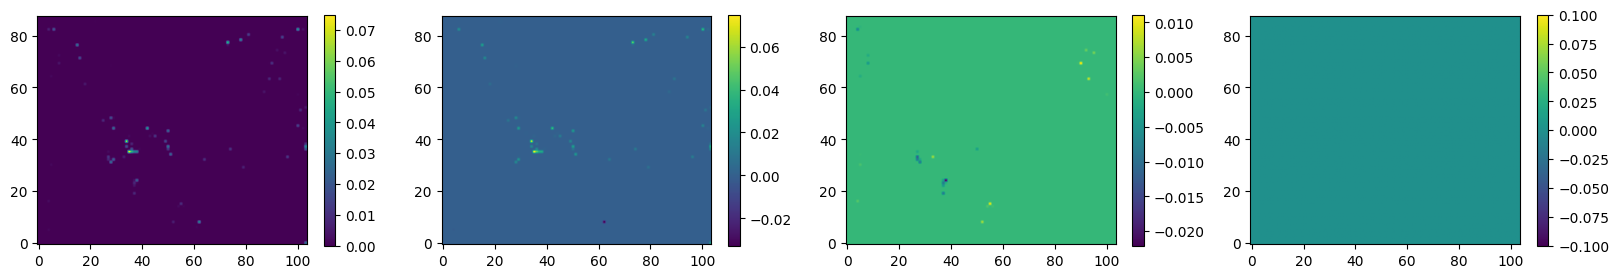

In [21]:
w_ = _Lasso.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [ ]:
_EN = ElasticNet(alpha         = EN_params_[18][0],
                 l1_ratio      = EN_params_[18][1],
                 max_iter      = 1000,
                 tol           = 1e-2,
                 fit_intercept = True).fit(X_tr_p_, y_tr_p_)
print(_EN.coef_.shape, _EN.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_EN.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

In [ ]:
w_ = _EN.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [91]:
idx_tr_ = y_tr_[:, 0] > 10.
idx_ts_ = y_ts_[:, 0] > 10.
print(y_tr_.shape, X_tr_p_.shape, idx_tr_.sum())
      
_Ridge = Ridge(alpha         = Ridge_params_[32],
               tol           = 1e-3,
               fit_intercept = True).fit(X_tr_p_[idx_tr_, :], y_tr_p_[idx_tr_])
print(_Ridge.coef_.shape, _Ridge.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_Ridge.predict(X_ts_p_)[:, np.newaxis])

(5058, 1) (5058, 9152) 2853
(9152,) None


In [92]:
RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

353.41052571174555 325.3209412949518 0.7564995419327806


In [93]:
RMSE = np.sqrt(mean_squared_error(y_ts_[idx_ts_], y_ts_hat_[idx_ts_]))
MAE  = mean_absolute_error(y_ts_[idx_ts_], y_ts_hat_[idx_ts_])
R2   = r2_score(y_ts_[idx_ts_], y_ts_hat_[idx_ts_])
print(RMSE, MAE, R2)

#313.30983158949215 254.68379820600228 0.7472094178133251
#309.88889129983096 238.77032054679017 0.75269957643639
#315.52923974379036 248.78647558207473 0.7436153229251501
#311.194843175365 234.27475080366426 0.7506108085929528

315.4120118078446 271.31652224470383 0.7438057956896178


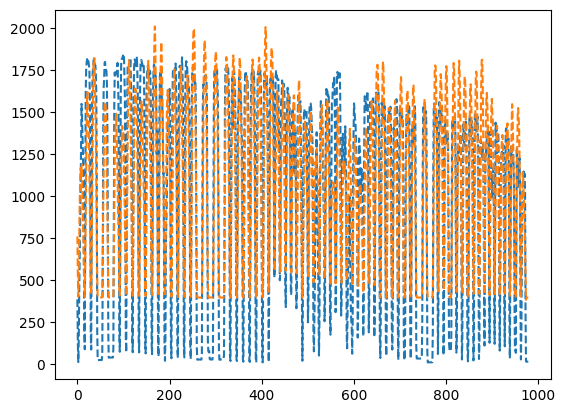

In [95]:
plt.figure()
plt.plot(y_ts_[idx_ts_], '--')
plt.plot(y_ts_hat_[idx_ts_], '--')
plt.show()

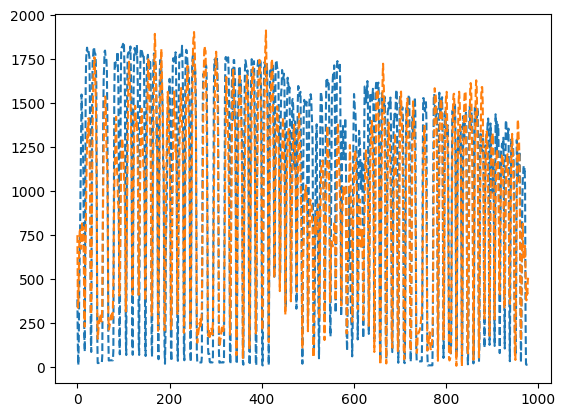

In [58]:
plt.figure()
plt.plot(y_ts_[idx_ts_], '--')
plt.plot(y_ts_hat_[idx_ts_], '--')
plt.show()

(3, 9152)


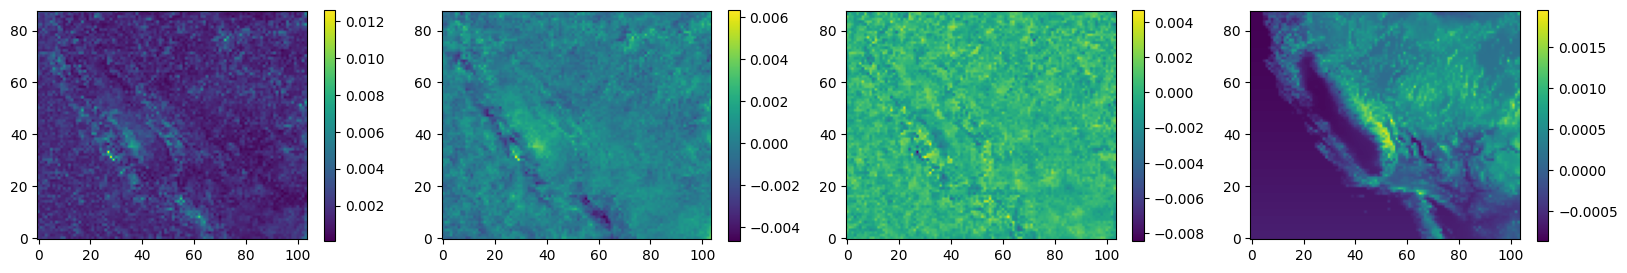

In [15]:
w_ = _Ridge.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [4]:
_Lars = Lars(eps             = Lars_params_[28][0],
             n_nonzero_coefs = Lars_params_[28][1],
             normalize       = False,
             fit_intercept   = True).fit(X_tr_p_, y_tr_p_)
print(_Lars.coef_.shape, _Lars.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_Lars.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

(27456,) 11050
214.33976185836414 156.83353299944633 0.876836674060761


(3, 9152)


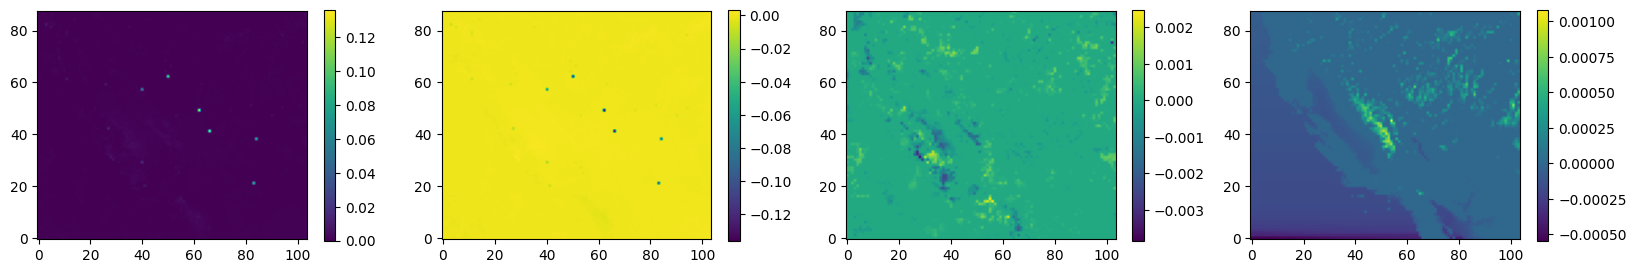

In [5]:
w_ = _Lars.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [30]:
_LL = LassoLars(alpha           = LL_params_[4][0],
                eps             = LL_params_[4][1],
                normalize       = False,
                max_iter        = 1,
                fit_intercept   = True).fit(X_tr_p_, y_tr_p_)
print(_LL.coef_.shape, _LL.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_LL.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

(27456,) 500
668.383874064245 628.1644931265558 0.12905095182508997


(3, 9152)


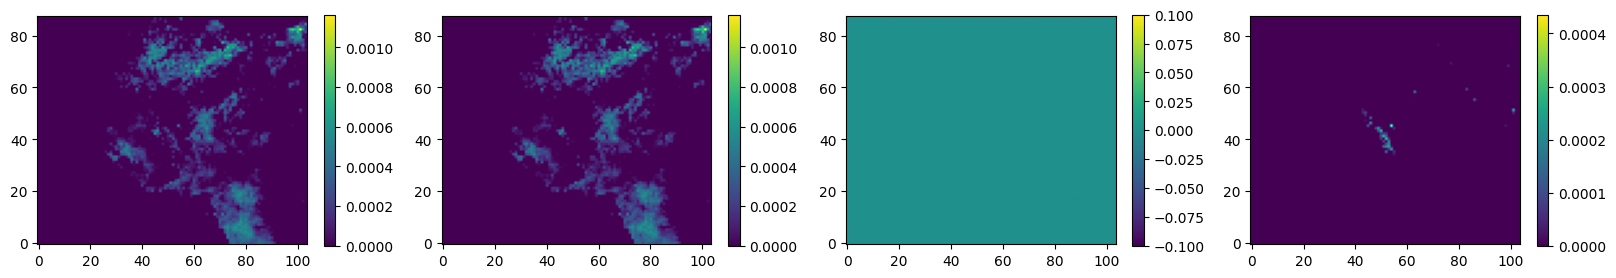

In [29]:
w_ = _LL.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [ ]:
_ARD = ARDRegression(threshold_lambda = ARD_params_[3],
                     n_iter           = 100,
                     tol              = 1.,
                     fit_intercept    = True).fit(X_tr_p_, y_tr_p_)
print(_ARD.coef_.shape, _ARD.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_ARD.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

In [ ]:
w_ = _ARD.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

In [10]:
_OMP = OrthogonalMatchingPursuit(n_nonzero_coefs = 10,
                                 normalize       = False,
                                 fit_intercept   = True).fit(X_tr_p_, y_tr_p_)
print(_OMP.coef_.shape, _OMP.n_nonzero_coefs_, _OMP.n_iter_)

y_ts_hat_ = _y_scaler.inverse_transform(_OMP.predict(X_ts_p_)[:, np.newaxis])

RMSE = np.sqrt(mean_squared_error(y_ts_, y_ts_hat_))
MAE  = mean_absolute_error(y_ts_, y_ts_hat_)
R2   = r2_score(y_ts_, y_ts_hat_)
print(RMSE, MAE, R2)

(27456,) 10 10
271.415694315217 210.1565312500965 0.8563813845149055


(3, 9152)


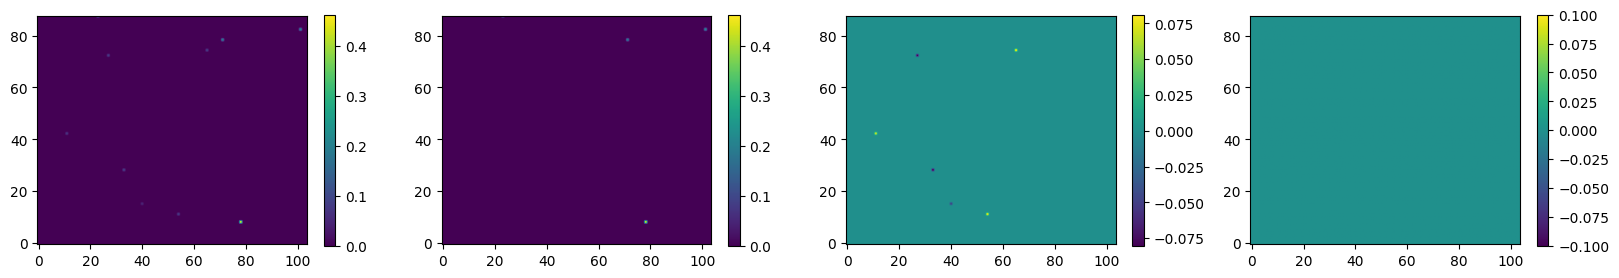

In [16]:
w_ = _OMP.coef_

N_features   = 3
N_dimensions = int(w_.shape[0]/N_features)

W_ = np.reshape(w_, (N_features, N_dimensions))
print(W_.shape)

plt.figure(figsize = (20, 3))
plt.subplot(141)
plt.imshow(np.sum(np.sqrt(np.reshape(W_, (N_features, M, N))**2), axis = 0), origin = 'lower')
plt.colorbar()
plt.subplot(142)
plt.imshow(np.reshape(W_[0, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(143)
plt.imshow(np.reshape(W_[1, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.subplot(144)
plt.imshow(np.reshape(W_[2, ...], (M, N)), origin = 'lower')
plt.colorbar()
plt.show()

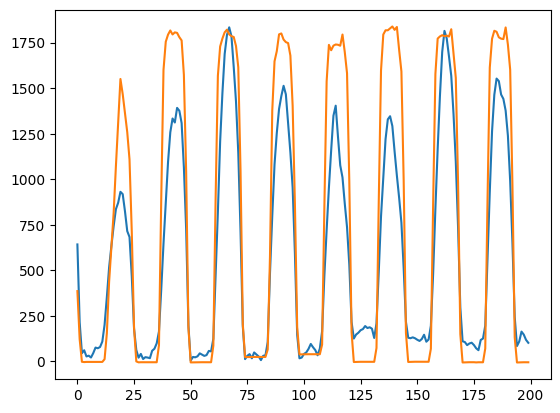

In [20]:
plt.figure()
plt.plot(y_ts_hat_[:200])
plt.plot(y_ts_[:200])
plt.show()